# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree


# Load and prepare dataset

In [3]:
dataset = pd.read_csv("../data/titanic/titanic.csv")

In [4]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Classification

## Datasets

In [39]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age", "Cabin_label", "Fare"]
target = "Survived"

X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=features, categorical_feature=["Sex_label", "Pclass"])
valid_data = lgb.Dataset(data=X_test, label=y_test, feature_name=features, categorical_feature=["Sex_label", "Pclass"])


## Model training

In [40]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 2,      # Data set is quite small so reduce this a bit
    'feature_pre_filter': False,
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data], verbose_eval=False)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/tudorl/Documents/workspace/personal/dtreeviz/venv/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


## LightGBM default visualisations

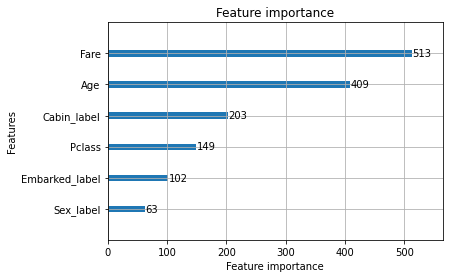

In [36]:
lgb.plot_importance(lgbm_model)

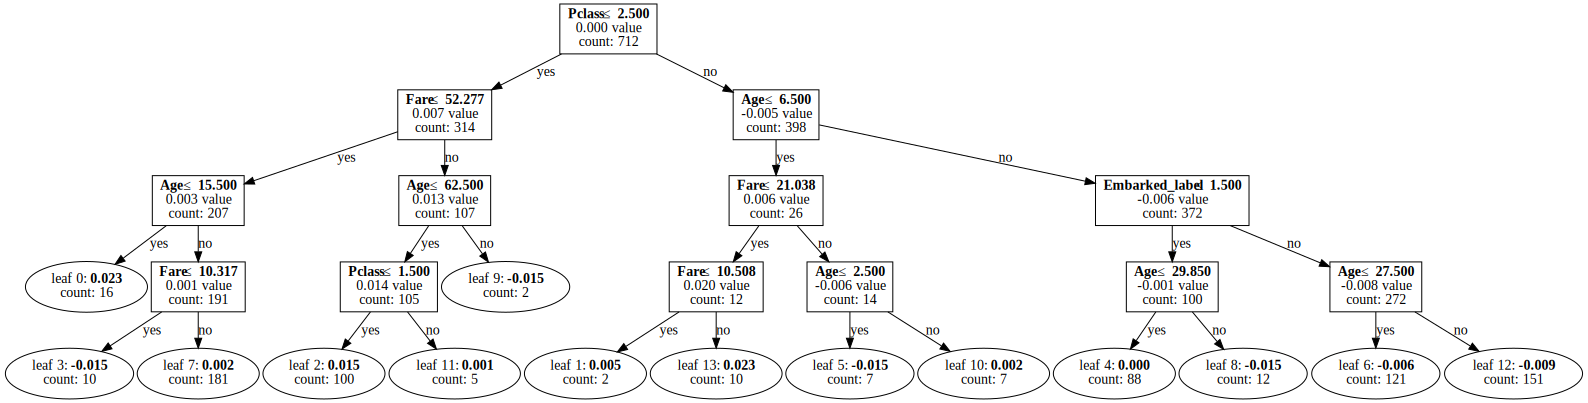

In [9]:
lgb.create_tree_digraph(lgbm_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])


## dtreeviz visualizations

In [10]:
light_dtree = ShadowLightGBMTree(lgbm_model, tree_index=1, x_data=X_train, y_data=y_train, feature_names=features, target_name=target, class_names=[0,1] )


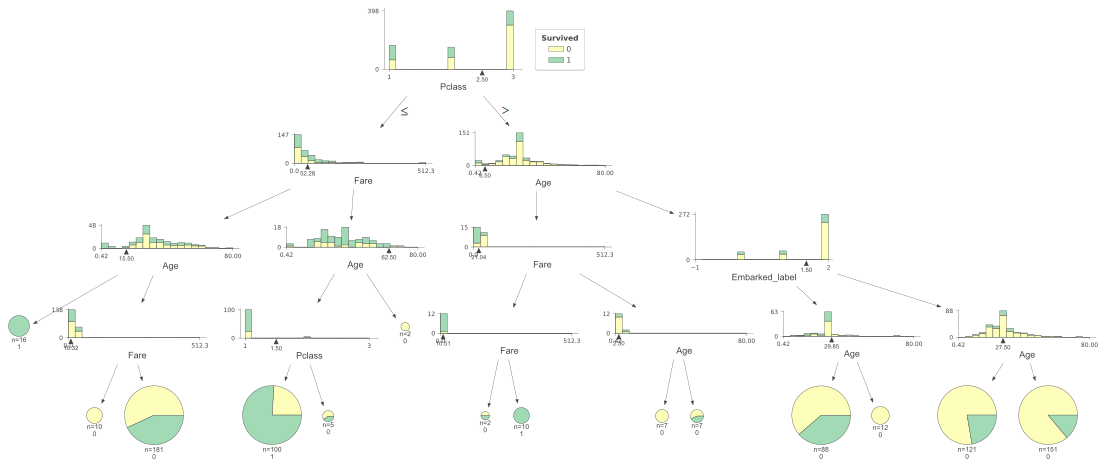

In [11]:
trees.dtreeviz(light_dtree)

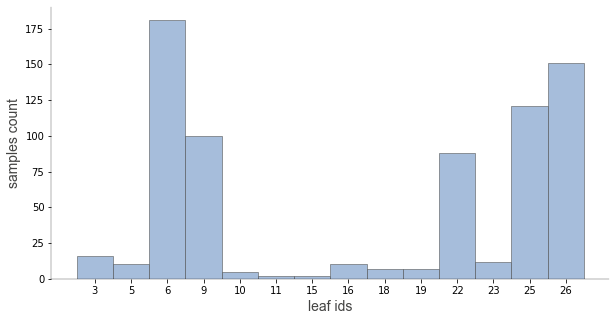

In [18]:
trees.viz_leaf_samples(light_dtree)

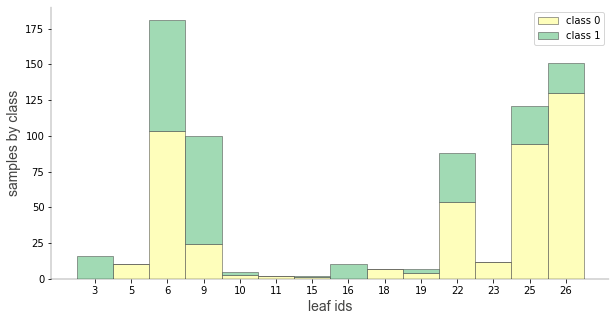

In [19]:
trees.ctreeviz_leaf_samples(light_dtree)

In [20]:
trees.describe_node_sample(light_dtree, node_id=5)

,Pclass,Sex_label,Embarked_label,Age,Cabin_label,Fare
count,10.000000,10.0,10.0,10.000000,10.000000,10.000000
mean,1.500000,1.0,2.0,31.989382,10.100000,0.500000
std,0.527046,0.0,0.0,4.096846,17.110426,1.581139
min,1.000000,1.0,2.0,29.699118,-1.000000,0.000000
25%,1.000000,1.0,2.0,29.699118,-1.000000,0.000000
50%,1.500000,1.0,2.0,29.699118,-1.000000,0.000000
75%,2.000000,1.0,2.0,32.174779,14.750000,0.000000
max,2.000000,1.0,2.0,40.000000,46.000000,5.000000


In [27]:
x = X_train[features].iloc[10]
print(x)

Pclass             2.0
Sex_label          0.0
Embarked_label     2.0
Age               42.0
Cabin_label       -1.0
Fare              13.0
Name: 865, dtype: float64


In [28]:
print(trees.explain_prediction_path(light_dtree, x=x))

Pclass < 2.5
15.5 <= Age 
10.32 <= Fare  < 52.28



# Regression

## Datasets

In [41]:
features_reg = ["Pclass", "Survived", "Sex_label", "Cabin_label", "Embarked_label"]
target_reg = "Age"

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(dataset[features_reg], dataset[target_reg], test_size=0.2, random_state=42)

categorical_feature=["Pclass", "Survived", "Sex_label"]
train_data_reg = lgb.Dataset(data=X_train_reg, label=y_train_reg)
valid_data_reg = lgb.Dataset(data=X_test_reg, label=y_test_reg)

lgbm_params = {
    'num_tree':10,
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'regression_l1',     
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}


## Model training

In [43]:
lgbm_reg_model = lgb.train(lgbm_params, train_data_reg, valid_sets=[train_data_reg, valid_data_reg], categorical_feature=categorical_feature, verbose_eval=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] Start training from score 29.699118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## LightGBM default visualisations

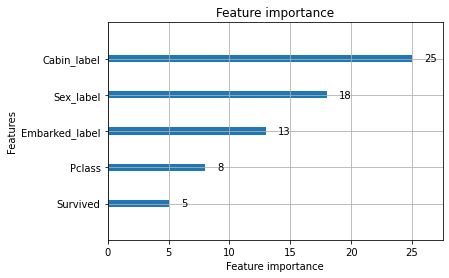

In [19]:
lgb.plot_importance(lgbm_reg_model)

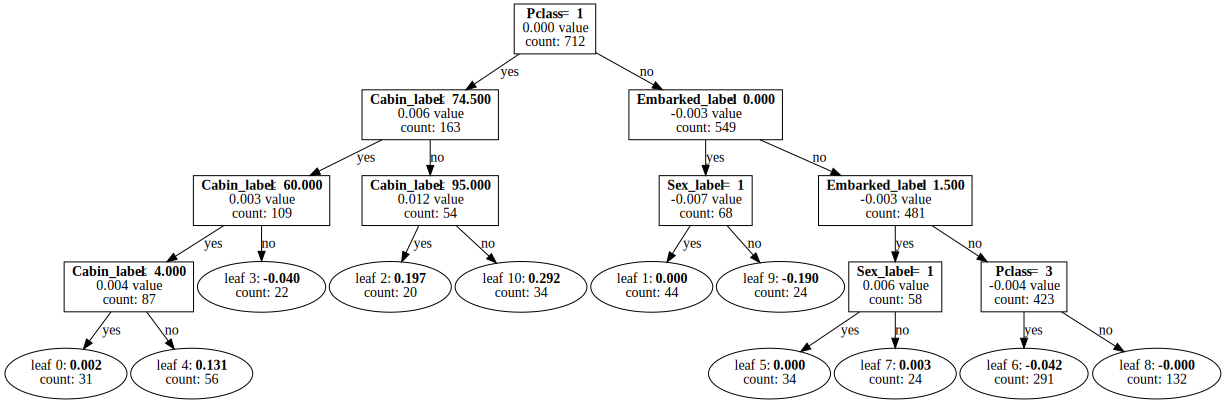

In [20]:
lgb.create_tree_digraph(lgbm_reg_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])


## dtreeviz visualisations

In [21]:
light_dtree_reg = ShadowLightGBMTree(lgbm_reg_model, tree_index=1, x_data=X_train_reg, y_data=y_train_reg, feature_names=features_reg, target_name=target_reg)


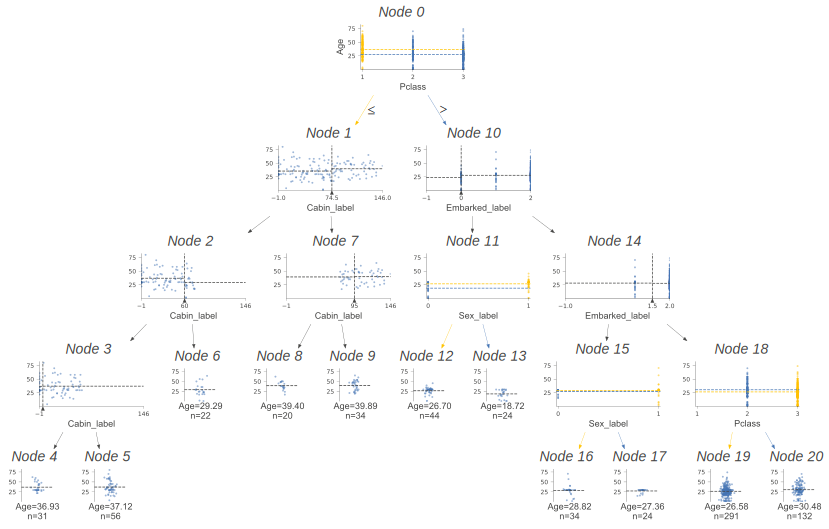

In [22]:
trees.dtreeviz(light_dtree_reg, show_node_labels=True)

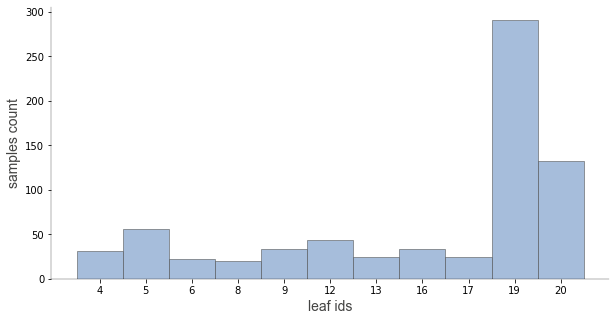

In [23]:
trees.viz_leaf_samples(light_dtree_reg)

In [24]:
trees.describe_node_sample(light_dtree_reg, node_id=14)

,Pclass,Survived,Sex_label,Cabin_label,Embarked_label
count,481.000000,481.000000,481.000000,481.000000,481.000000
mean,2.719335,0.291060,0.686071,4.869023,1.879418
std,0.449792,0.454724,0.464571,27.624972,0.325980
min,2.000000,0.000000,0.000000,-1.000000,1.000000
25%,2.000000,0.000000,0.000000,-1.000000,2.000000
50%,3.000000,0.000000,1.000000,-1.000000,2.000000
75%,3.000000,1.000000,1.000000,-1.000000,2.000000
max,3.000000,1.000000,1.000000,145.000000,2.000000


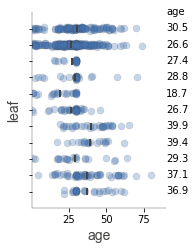

In [25]:
trees.viz_leaf_target(light_dtree_reg)

In [26]:
x = X_train_reg[features_reg].iloc[25]
x

Pclass            3
Survived          1
Sex_label         1
Cabin_label      -1
Embarked_label    0
Name: 762, dtype: int64

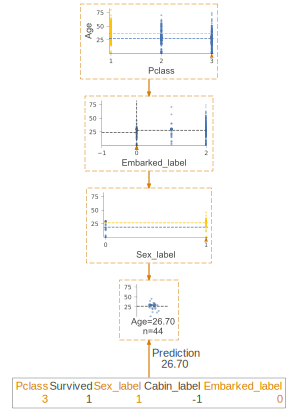

In [27]:
trees.dtreeviz(light_dtree_reg, X=x, show_just_path=True)

In [28]:
print(trees.explain_prediction_path(light_dtree_reg, x))

0.0 <= Embarked_label 
Pclass in [] 
Sex_label in [1] 

